# Clustering CD34 image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell CD34 channel cropped image to cluster the cells and identify which are leukemia cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
!python --version

Python 3.8.5


In [3]:
from os import listdir
from os.path import isfile, join

In [36]:
pt = 'P52'

### Read in counts tables to obtain raw marker expression per cell

In [37]:
# read in counts tables from each fov
counts_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/3_GenerateCounts/' + pt + '_hybrid_counts/'
tables = [f for f in listdir(counts_dir) if isfile(join(counts_dir, f))]
tables.sort()

In [38]:
# create all-fov counts table
all_fovs = pd.read_csv(counts_dir + tables[0], index_col=0, comment='#')

for i in range(1,len(tables)):
    data = pd.read_csv(counts_dir + tables[i], index_col=0, comment='#')
    all_fovs = pd.concat([all_fovs, data])

# add column to sepecify patient
all_fovs['Patient'] = pt
# convert FOV number to 2-digit string
all_fovs['fov'] = all_fovs['fov'].astype(str).str.zfill(2)
all_fovs['cell_ID'] = all_fovs['cell_ID'].astype(int)
all_fovs.head()

fov  cell_ID   x_global_px    y_global_px  x_local_px  y_local_px  z  \
0  01     1336  56485.253333  161131.948889     1801.92    1843.060 -1   
1  01     2116  57535.813333  160454.558889     2852.48    1165.670 -1   
2  01        0  55298.333333  160343.888889      615.00    1055.000 -1   
3  01      325  57325.043333  162370.559889     2641.71    3081.671 -1   
4  01      198  57875.133333  162620.410889     3191.80    3331.522 -1   

     target  Size (pixels)   CD298_total  ...    CD45_total    CD45_mean  \
0     MMP14           3538  4.126210e+07  ...  4.814842e+06  1360.893851   
1     PTHLH           2186  1.161997e+07  ...  3.303348e+06  1511.138254   
2  NegPrb18              0  0.000000e+00  ...  0.000000e+00     0.000000   
3    FCER1G          13449  1.739649e+08  ...  1.653229e+07  1229.258194   
4      RGCC           3154  3.263368e+07  ...  3.865891e+06  1225.710456   

   CD45_median    CD34_total    CD34_mean  CD34_median    DAPI_total  \
0  1304.888889  6.269024e+06  1771.911720  1755.611111  1.822689e+06   
1  1475.166667  5.160955e+06  2360.912575  2199.833333  6.127900e+05   
2     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
3  1197.777778  1.936639e+07  1439.987351  1421.333333  3.326970e+06   
4  1163.666667  4.647773e+06  1473.612168  1438.000000  1.525190e+06   

    DAPI_mean  DAPI_median  Patient  
0  515.174926   327.166667      P52  
1  280.324794   218.611111      P52  
2    0.000000     0.000000      P52  
3  247.376732   185.888889      P52  
4  483.573205   383.500000      P52  

[5 rows x 25 columns]

In [39]:
# create unique ID for each cell (patient + FOV + cell number)
all_fovs['New_ID'] = all_fovs['Patient'] + '_FOV' + all_fovs['fov'] + "_cell_" + all_fovs["cell_ID"].astype(str)
all_fovs

fov  cell_ID   x_global_px    y_global_px  x_local_px  y_local_px  z  \
0         01     1336  56485.253333  161131.948889     1801.92    1843.060 -1   
1         01     2116  57535.813333  160454.558889     2852.48    1165.670 -1   
2         01        0  55298.333333  160343.888889      615.00    1055.000 -1   
3         01      325  57325.043333  162370.559889     2641.71    3081.671 -1   
4         01      198  57875.133333  162620.410889     3191.80    3331.522 -1   
...       ..      ...           ...            ...         ...         ... ..   
17254458  25        0 -49306.664444  142106.064444     3137.78      11.620  1   
17254459  25        0 -49280.024444  142105.984444     3164.42      11.540  2   
17254460  25        0 -49276.534444  142105.744444     3167.91      11.300  3   
17254461  25        0 -49299.224444  142106.674444     3145.22      12.230  6   
17254462  25        0 -49303.994444  142105.844444     3140.45      11.400  6   

             target  Size (pixels)   CD298_total  ...    CD45_mean  \
0             MMP14           3538  4.126210e+07  ...  1360.893851   
1             PTHLH           2186  1.161997e+07  ...  1511.138254   
2          NegPrb18              0  0.000000e+00  ...     0.000000   
3            FCER1G          13449  1.739649e+08  ...  1229.258194   
4              RGCC           3154  3.263368e+07  ...  1225.710456   
...             ...            ...           ...  ...          ...   
17254458  TNFRSF12A              0  0.000000e+00  ...     0.000000   
17254459      DUSP5              0  0.000000e+00  ...     0.000000   
17254460       NPPC              0  0.000000e+00  ...     0.000000   
17254461       FGF1              0  0.000000e+00  ...     0.000000   
17254462      DUSP5              0  0.000000e+00  ...     0.000000   

          CD45_median    CD34_total    CD34_mean  CD34_median    DAPI_total  \
0         1304.888889  6.269024e+06  1771.911720  1755.611111  1.822689e+06   
1         1475.166667  5.160955e+06  2360.912575  2199.833333  6.127900e+05   
2            0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
3         1197.777778  1.936639e+07  1439.987351  1421.333333  3.326970e+06   
4         1163.666667  4.647773e+06  1473.612168  1438.000000  1.525190e+06   
...               ...           ...          ...          ...           ...   
17254458     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
17254459     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
17254460     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
17254461     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   
17254462     0.000000  0.000000e+00     0.000000     0.000000  0.000000e+00   

           DAPI_mean  DAPI_median  Patient               New_ID  
0         515.174926   327.166667      P52  P52_FOV01_cell_1336  
1         280.324794   218.611111      P52  P52_FOV01_cell_2116  
2           0.000000     0.000000      P52     P52_FOV01_cell_0  
3         247.376732   185.888889      P52   P52_FOV01_cell_325  
4         483.573205   383.500000      P52   P52_FOV01_cell_198  
...              ...          ...      ...                  ...  
17254458    0.000000     0.000000      P52     P52_FOV25_cell_0  
17254459    0.000000     0.000000      P52     P52_FOV25_cell_0  
17254460    0.000000     0.000000      P52     P52_FOV25_cell_0  
17254461    0.000000     0.000000      P52     P52_FOV25_cell_0  
17254462    0.000000     0.000000      P52     P52_FOV25_cell_0  

[17254463 rows x 26 columns]

In [40]:
# since current table has each row as a transcript read, remove duplicates so we have 1 entry per cell
all_fovs = all_fovs.drop_duplicates(subset='New_ID', keep='first', ignore_index=True)
all_fovs

fov  cell_ID   x_global_px    y_global_px  x_local_px  y_local_px  z  \
0       01     1336  56485.253333  161131.948889    1801.920    1843.060 -1   
1       01     2116  57535.813333  160454.558889    2852.480    1165.670 -1   
2       01        0  55298.333333  160343.888889     615.000    1055.000 -1   
3       01      325  57325.043333  162370.559889    2641.710    3081.671 -1   
4       01      198  57875.133333  162620.410889    3191.800    3331.522 -1   
...     ..      ...           ...            ...         ...         ... ..   
121174  25     3256 -52416.224444  142107.784444      28.220      13.340  2   
121175  25     8518 -51692.669444  142117.924444     751.775      23.480  3   
121176  25     8516 -48048.444444  142110.444444    4396.000      16.000  1   
121177  25     8522 -49639.164444  142106.724444    2805.280      12.280  1   
121178  25     8524 -52395.519444  142105.724444      48.925      11.280  1   

          target  Size (pixels)   CD298_total  ...    CD45_mean  CD45_median  \
0          MMP14           3538  4.126210e+07  ...  1360.893851  1304.888889   
1          PTHLH           2186  1.161997e+07  ...  1511.138254  1475.166667   
2       NegPrb18              0  0.000000e+00  ...     0.000000     0.000000   
3         FCER1G          13449  1.739649e+08  ...  1229.258194  1197.777778   
4           RGCC           3154  3.263368e+07  ...  1225.710456  1163.666667   
...          ...            ...           ...  ...          ...          ...   
121174     DUSP5            814  5.818562e+06  ...  1557.822823  1501.388889   
121175     CXCL9            728  3.267755e+06  ...  1744.894078  1770.611111   
121176  NegPrb18            975  6.559137e+06  ...  1929.308490  1960.555556   
121177      AZU1            908  1.336803e+07  ...  2461.894518  2082.722222   
121178      PNOC            653  4.368223e+06  ...  1788.683002  1606.888889   

          CD34_total    CD34_mean  CD34_median    DAPI_total    DAPI_mean  \
0       6.269024e+06  1771.911720  1755.611111  1.822689e+06   515.174926   
1       5.160955e+06  2360.912575  2199.833333  6.127900e+05   280.324794   
2       0.000000e+00     0.000000     0.000000  0.000000e+00     0.000000   
3       1.936639e+07  1439.987351  1421.333333  3.326970e+06   247.376732   
4       4.647773e+06  1473.612168  1438.000000  1.525190e+06   483.573205   
...              ...          ...          ...           ...          ...   
121174  1.583621e+06  1945.480344  1740.722222  9.608483e+05  1180.403358   
121175  1.223598e+06  1680.766026  1684.166667  3.207392e+05   440.575855   
121176  1.950054e+06  2000.055613  2008.222222  6.551538e+05   671.952593   
121177  7.337048e+06  8080.449217  5682.888889  1.688115e+06  1859.157734   
121178  1.874486e+06  2870.575804  2178.666667  1.263384e+06  1934.738642   

        DAPI_median  Patient               New_ID  
0        327.166667      P52  P52_FOV01_cell_1336  
1        218.611111      P52  P52_FOV01_cell_2116  
2          0.000000      P52     P52_FOV01_cell_0  
3        185.888889      P52   P52_FOV01_cell_325  
4        383.500000      P52   P52_FOV01_cell_198  
...             ...      ...                  ...  
121174  1291.611111      P52  P52_FOV25_cell_3256  
121175   453.833333      P52  P52_FOV25_cell_8518  
121176   710.555556      P52  P52_FOV25_cell_8516  
121177  1930.666667      P52  P52_FOV25_cell_8522  
121178  2000.111111      P52  P52_FOV25_cell_8524  

[121179 rows x 26 columns]

In [41]:
# 0 does not correspond to a real cell, drop from DF
all_fovs_metadata = all_fovs.drop(all_fovs[all_fovs['cell_ID'] == 0].index)

In [42]:
# set unique cell ID as DF index
all_fovs_metadata = all_fovs_metadata.set_index('New_ID')
all_fovs_metadata.head()

fov  cell_ID   x_global_px    y_global_px  x_local_px  \
New_ID                                                                      
P52_FOV01_cell_1336  01     1336  56485.253333  161131.948889     1801.92   
P52_FOV01_cell_2116  01     2116  57535.813333  160454.558889     2852.48   
P52_FOV01_cell_325   01      325  57325.043333  162370.559889     2641.71   
P52_FOV01_cell_198   01      198  57875.133333  162620.410889     3191.80   
P52_FOV01_cell_610   01      610  57373.093333  162027.528889     2689.76   

                     y_local_px  z  target  Size (pixels)   CD298_total  ...  \
New_ID                                                                   ...   
P52_FOV01_cell_1336    1843.060 -1   MMP14           3538  4.126210e+07  ...   
P52_FOV01_cell_2116    1165.670 -1   PTHLH           2186  1.161997e+07  ...   
P52_FOV01_cell_325     3081.671 -1  FCER1G          13449  1.739649e+08  ...   
P52_FOV01_cell_198     3331.522 -1    RGCC           3154  3.263368e+07  ...   
P52_FOV01_cell_610     2738.640 -1   CXCL5           1919  1.235402e+07  ...   

                       CD45_total    CD45_mean  CD45_median    CD34_total  \
New_ID                                                                      
P52_FOV01_cell_1336  4.814842e+06  1360.893851  1304.888889  6.269024e+06   
P52_FOV01_cell_2116  3.303348e+06  1511.138254  1475.166667  5.160955e+06   
P52_FOV01_cell_325   1.653229e+07  1229.258194  1197.777778  1.936639e+07   
P52_FOV01_cell_198   3.865891e+06  1225.710456  1163.666667  4.647773e+06   
P52_FOV01_cell_610   3.675119e+06  1915.121707  1380.777778  6.015359e+06   

                       CD34_mean  CD34_median    DAPI_total   DAPI_mean  \
New_ID                                                                    
P52_FOV01_cell_1336  1771.911720  1755.611111  1.822689e+06  515.174926   
P52_FOV01_cell_2116  2360.912575  2199.833333  6.127900e+05  280.324794   
P52_FOV01_cell_325   1439.987351  1421.333333  3.326970e+06  247.376732   
P52_FOV01_cell_198   1473.612168  1438.000000  1.525190e+06  483.573205   
P52_FOV01_cell_610   3134.631984  1849.333333  4.838864e+05  252.155521   

                     DAPI_median  Patient  
New_ID                                     
P52_FOV01_cell_1336   327.166667      P52  
P52_FOV01_cell_2116   218.611111      P52  
P52_FOV01_cell_325    185.888889      P52  
P52_FOV01_cell_198    383.500000      P52  
P52_FOV01_cell_610    227.777778      P52  

[5 rows x 25 columns]

### Read in feature matrix as csv

In [43]:
# read in features from each fov
feats_dir = 'Normalized_CD34_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [44]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

0         1         2         3         4  \
P52_FOV01_cell_1     0.405462  2.674960  3.191028  2.746600  0.529273   
P52_FOV01_cell_2     0.405799  2.674589  3.190816  2.746712  0.529433   
P52_FOV01_cell_3     0.405650  2.674674  3.190876  2.746675  0.529383   
P52_FOV01_cell_4     0.408760  2.674816  3.189230  2.747375  0.530940   
P52_FOV01_cell_5     0.407530  2.674908  3.189987  2.747067  0.530240   
...                       ...       ...       ...       ...       ...   
P52_FOV25_cell_8524  0.392601  2.725499  3.141053  2.707727  0.527572   
P52_FOV25_cell_8525  0.404934  2.675076  3.191288  2.746464  0.529062   
P52_FOV25_cell_8526  0.406025  2.661105  3.141588  2.699021  0.538625   
P52_FOV25_cell_8527  0.403355  2.668605  3.160334  2.702882  0.538089   
P52_FOV25_cell_8528  0.405979  2.672873  3.190554  2.738289  0.530763   

                            5         6         7         8         9  ...  \
P52_FOV01_cell_1     0.363357  2.388934 -0.162229  0.791361  0.274618  ...   
P52_FOV01_cell_2     0.363357  2.388917 -0.162228  0.791378  0.274603  ...   
P52_FOV01_cell_3     0.363372  2.388928 -0.162230  0.791354  0.274607  ...   
P52_FOV01_cell_4     0.362255  2.387634 -0.161971  0.791219  0.274603  ...   
P52_FOV01_cell_5     0.362646  2.388122 -0.162096  0.791198  0.274584  ...   
...                       ...       ...       ...       ...       ...  ...   
P52_FOV25_cell_8524  0.373690  2.354154 -0.153047  0.786474  0.276207  ...   
P52_FOV25_cell_8525  0.363450  2.389105 -0.162251  0.791281  0.274635  ...   
P52_FOV25_cell_8526  0.374379  2.344377 -0.151755  0.790967  0.280163  ...   
P52_FOV25_cell_8527  0.368107  2.357649 -0.158249  0.779834  0.275167  ...   
P52_FOV25_cell_8528  0.366113  2.380526 -0.149756  0.791270  0.275361  ...   

                          662       663       664       665       666  \
P52_FOV01_cell_1     0.534064 -0.050179  0.059997 -0.030655  1.725682   
P52_FOV01_cell_2     0.534578 -0.050239  0.060001 -0.030685  1.725447   
P52_FOV01_cell_3     0.534416 -0.050203  0.059981 -0.030674  1.725558   
P52_FOV01_cell_4     0.538377 -0.050865  0.059648 -0.030473  1.722689   
P52_FOV01_cell_5     0.536805 -0.050603  0.059575 -0.030567  1.723748   
...                       ...       ...       ...       ...       ...   
P52_FOV25_cell_8524  0.496732 -0.052539  0.226055 -0.017681  1.739565   
P52_FOV25_cell_8525  0.533430 -0.050076  0.060046 -0.030632  1.726132   
P52_FOV25_cell_8526  0.524175 -0.043450  0.188924 -0.019357  1.726276   
P52_FOV25_cell_8527  0.514876 -0.044940  0.166494 -0.015507  1.732626   
P52_FOV25_cell_8528  0.531274 -0.050409  0.105621 -0.026236  1.725323   

                          667       668       669       670       671  
P52_FOV01_cell_1     0.148126  3.447325 -0.078422  0.621493 -0.041527  
P52_FOV01_cell_2     0.148228  3.447481 -0.077903  0.621727 -0.041598  
P52_FOV01_cell_3     0.148192  3.447425 -0.078075  0.621636 -0.041572  
P52_FOV01_cell_4     0.149059  3.448677 -0.074834  0.626434 -0.042973  
P52_FOV01_cell_5     0.148726  3.448227 -0.076173  0.624674 -0.042356  
...                       ...       ...       ...       ...       ...  
P52_FOV25_cell_8524  0.145235  3.456203 -0.099536  0.615902 -0.028913  
P52_FOV25_cell_8525  0.147993  3.447053 -0.079007  0.620932 -0.041429  
P52_FOV25_cell_8526  0.154557  3.461747 -0.067298  0.624064 -0.041537  
P52_FOV25_cell_8527  0.152815  3.464902 -0.069364  0.604849 -0.031671  
P52_FOV25_cell_8528  0.149619  3.446989 -0.079386  0.616169 -0.041559  

[121857 rows x 672 columns]

In [45]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_CD34_features.csv", header=False)

In [46]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_CD34_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 121857 × 672

In [47]:
adata.obs

Empty DataFrame
Columns: []
Index: [P52_FOV01_cell_1, P52_FOV01_cell_2, P52_FOV01_cell_3, P52_FOV01_cell_4, P52_FOV01_cell_5, P52_FOV01_cell_6, P52_FOV01_cell_7, P52_FOV01_cell_8, P52_FOV01_cell_9, P52_FOV01_cell_10, P52_FOV01_cell_11, P52_FOV01_cell_12, P52_FOV01_cell_13, P52_FOV01_cell_14, P52_FOV01_cell_15, P52_FOV01_cell_16, P52_FOV01_cell_17, P52_FOV01_cell_18, P52_FOV01_cell_19, P52_FOV01_cell_20, P52_FOV01_cell_21, P52_FOV01_cell_22, P52_FOV01_cell_23, P52_FOV01_cell_24, P52_FOV01_cell_25, P52_FOV01_cell_26, P52_FOV01_cell_27, P52_FOV01_cell_28, P52_FOV01_cell_29, P52_FOV01_cell_30, P52_FOV01_cell_31, P52_FOV01_cell_32, P52_FOV01_cell_33, P52_FOV01_cell_34, P52_FOV01_cell_35, P52_FOV01_cell_36, P52_FOV01_cell_37, P52_FOV01_cell_38, P52_FOV01_cell_39, P52_FOV01_cell_40, P52_FOV01_cell_41, P52_FOV01_cell_42, P52_FOV01_cell_43, P52_FOV01_cell_44, P52_FOV01_cell_45, P52_FOV01_cell_46, P52_FOV01_cell_47, P52_FOV01_cell_48, P52_FOV01_cell_49, P52_FOV01_cell_50, P52_FOV01_cell_51, P52_FOV01_cell_52, P52_FOV01_cell_53, P52_FOV01_cell_54, P52_FOV01_cell_55, P52_FOV01_cell_56, P52_FOV01_cell_57, P52_FOV01_cell_58, P52_FOV01_cell_59, P52_FOV01_cell_60, P52_FOV01_cell_61, P52_FOV01_cell_62, P52_FOV01_cell_63, P52_FOV01_cell_64, P52_FOV01_cell_65, P52_FOV01_cell_66, P52_FOV01_cell_67, P52_FOV01_cell_68, P52_FOV01_cell_69, P52_FOV01_cell_70, P52_FOV01_cell_71, P52_FOV01_cell_72, P52_FOV01_cell_73, P52_FOV01_cell_74, P52_FOV01_cell_75, P52_FOV01_cell_76, P52_FOV01_cell_77, P52_FOV01_cell_78, P52_FOV01_cell_79, P52_FOV01_cell_80, P52_FOV01_cell_81, P52_FOV01_cell_82, P52_FOV01_cell_83, P52_FOV01_cell_84, P52_FOV01_cell_85, P52_FOV01_cell_86, P52_FOV01_cell_87, P52_FOV01_cell_88, P52_FOV01_cell_89, P52_FOV01_cell_90, P52_FOV01_cell_91, P52_FOV01_cell_92, P52_FOV01_cell_93, P52_FOV01_cell_94, P52_FOV01_cell_95, P52_FOV01_cell_96, P52_FOV01_cell_97, P52_FOV01_cell_98, P52_FOV01_cell_99, P52_FOV01_cell_100, ...]

[121857 rows x 0 columns]

In [48]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

Timepoint Clinical outcome
P51_FOV01         A               PD
P51_FOV02         A               PD
P51_FOV03         A               PD
P51_FOV04         A               PD
P51_FOV05         A               PD
...             ...              ...
P58_FOV19         C               SD
P58_FOV20         C               SD
P58_FOV21         C               SD
P58_FOV22         C               SD
P58_FOV23         C               SD

[141 rows x 2 columns]

In [49]:
# get FOV and cell number from cell ID, timepoint from csv file

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_1830952/3782544952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_1830952/3782544952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


FOV cell_ID Timepoint
P52_FOV01_cell_1     01       1         A
P52_FOV01_cell_2     01       2         A
P52_FOV01_cell_3     01       3         A
P52_FOV01_cell_4     01       4         A
P52_FOV01_cell_5     01       5         A
...                  ..     ...       ...
P52_FOV25_cell_8524  25    8524         C
P52_FOV25_cell_8525  25    8525         C
P52_FOV25_cell_8526  25    8526         C
P52_FOV25_cell_8527  25    8527         C
P52_FOV25_cell_8528  25    8528         C

[121857 rows x 3 columns]

### Map protein expression values to appropriate cell IDs in feature table

In [50]:
adata.obs = adata.obs.merge(all_fovs_metadata[['Size (pixels)', 'CD34_median']], how='left', left_index=True, right_index=True)
adata.obs

FOV cell_ID Timepoint  Size (pixels)  CD34_median
P52_FOV01_cell_1     01       1         A          574.0   966.500000
P52_FOV01_cell_2     01       2         A         1483.0   959.222222
P52_FOV01_cell_3     01       3         A         1167.0   993.444444
P52_FOV01_cell_4     01       4         A         1275.0  1385.666667
P52_FOV01_cell_5     01       5         A          896.0  1536.277778
...                  ..     ...       ...            ...          ...
P52_FOV25_cell_8524  25    8524         C          653.0  2178.666667
P52_FOV25_cell_8525  25    8525         C            NaN          NaN
P52_FOV25_cell_8526  25    8526         C          736.0  5383.666667
P52_FOV25_cell_8527  25    8527         C            NaN          NaN
P52_FOV25_cell_8528  25    8528         C            NaN          NaN

[121857 rows x 5 columns]

### Remove cells classified as RBCs or not passing size filter

In [51]:
# read in list of cells that passed RBC & size filter
RBCs = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/2_FilterbySize/Cells_filtbyRBCandsize.csv', index_col=0)
ptRBCs = RBCs[RBCs['Patient'] == pt]
ptRBCs['Passed_QC'] = 1

/tmp/ipykernel_1830952/310710571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptRBCs['Passed_QC'] = 1


In [52]:
adata.obs = adata.obs.merge(ptRBCs['Passed_QC'], how='left', left_index=True, right_index=True)
adata

AnnData object with n_obs × n_vars = 121857 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC'

In [53]:
adata = adata[adata.obs['Passed_QC'] == 1]
adata

View of AnnData object with n_obs × n_vars = 94849 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC'

## Pre-Processing

### Log-Transformation

In [54]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [55]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

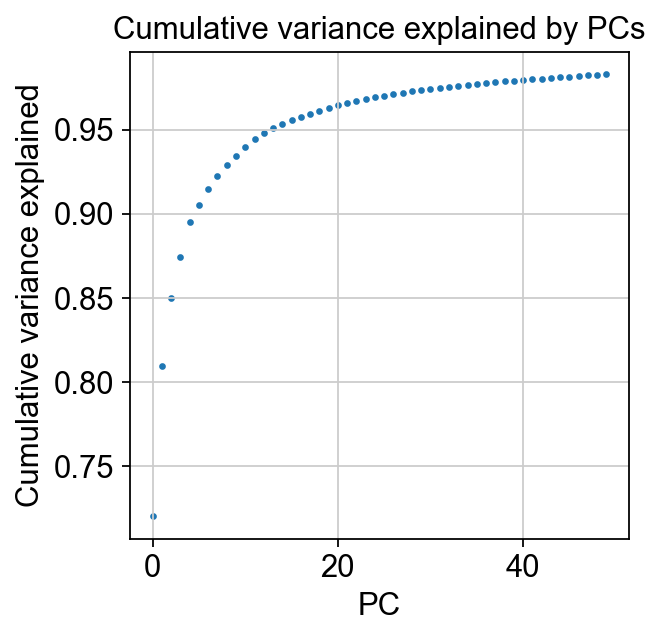

In [56]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [57]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [58]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 646.6741933822632 seconds
Jaccard graph constructed in 93.9287600517273 seconds
Wrote graph to binary file in 2.15140962600708 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.902626
Louvain completed 21 runs in 289.9546756744385 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1096.6238255500793 seconds


In [59]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


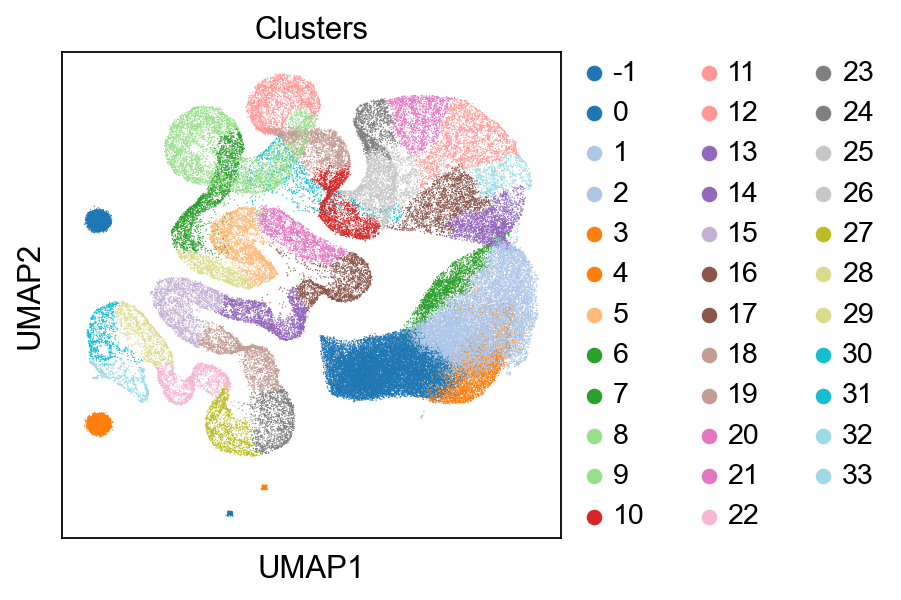

In [60]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

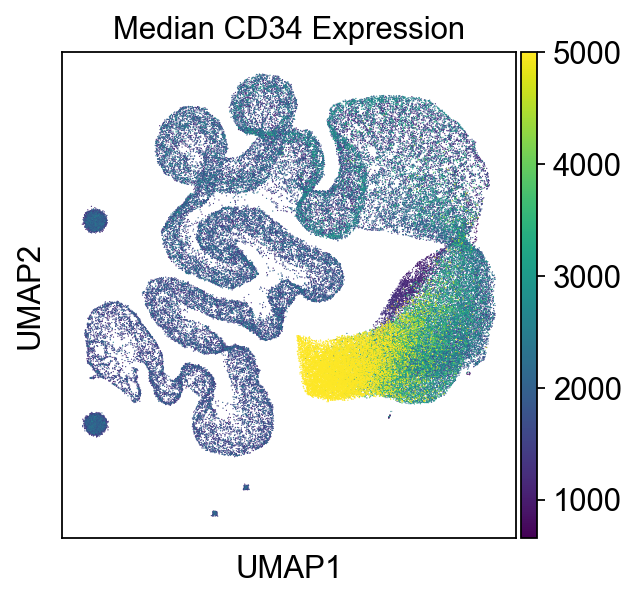

In [61]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=5000
)

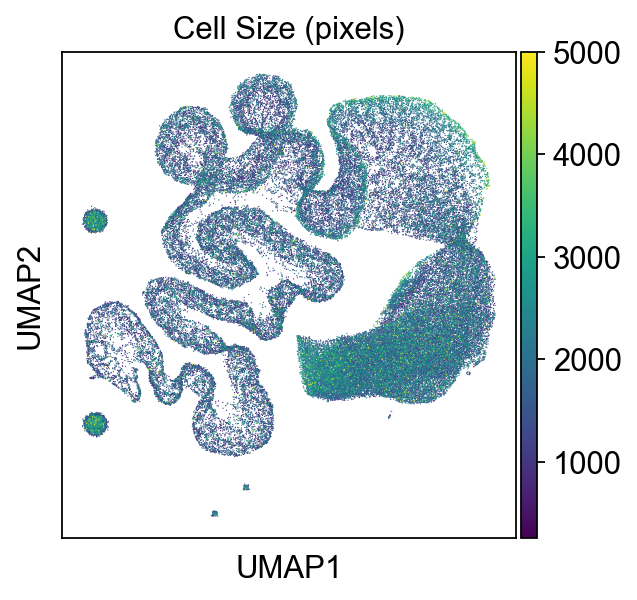

In [62]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


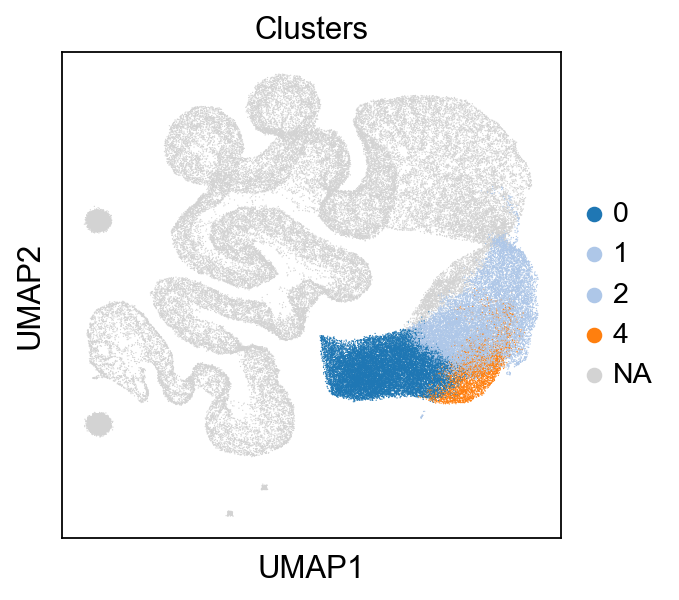

In [64]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,2,4]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


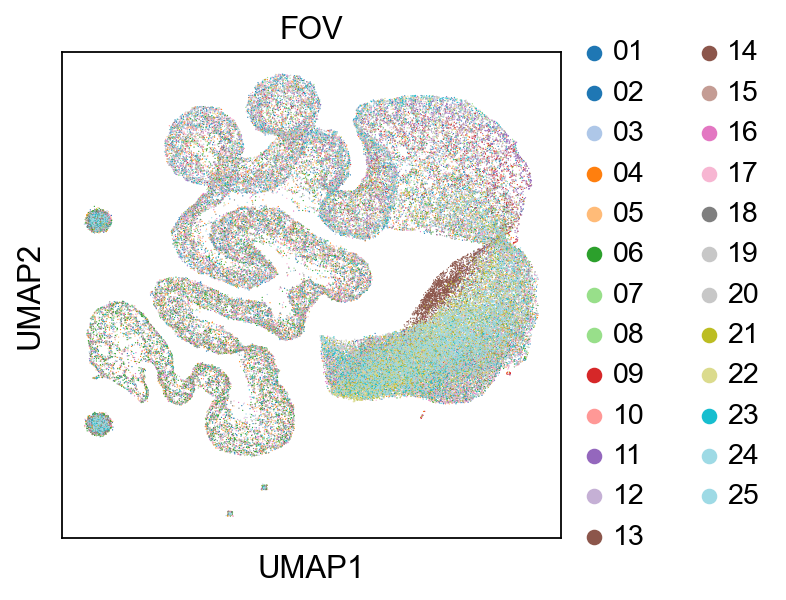

In [65]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [66]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_clusters.csv')

In [67]:
adata_all = adata

In [68]:
# save clustered data anndata object
adata_all.write_h5ad(pt + '_CD34_cell_features_clustered.h5ad')

## Sub-cluster CD34+ candidates (cluster 0,1,2,4)

In [69]:
adata = adata[adata.obs['PhenoGraph_clusters'].isin([0,1,2,4])]
adata.obs = adata.obs.rename(columns={"PhenoGraph_clusters": "PhenoGraph_clusters_round_1"})
adata

AnnData object with n_obs × n_vars = 34424 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint', 'Size (pixels)', 'CD34_median', 'Passed_QC', 'PhenoGraph_clusters_round_1'
    uns: 'pca', 'PhenoGraph_Q', 'PhenoGraph_k', 'neighbors', 'umap', 'PhenoGraph_clusters_colors', 'FOV_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Pre-Processing

### Log-Transformation

In [70]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [71]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

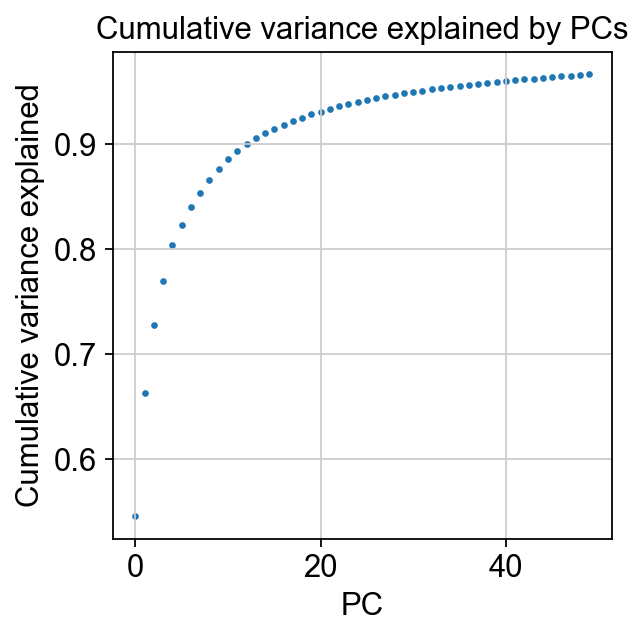

In [72]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [73]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [74]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 54.97351884841919 seconds
Jaccard graph constructed in 64.76107692718506 seconds
Wrote graph to binary file in 0.6288318634033203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782487
After 2 runs, maximum modularity is Q = 0.789359
Louvain completed 22 runs in 59.79167032241821 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 270.0887620449066 seconds


In [75]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


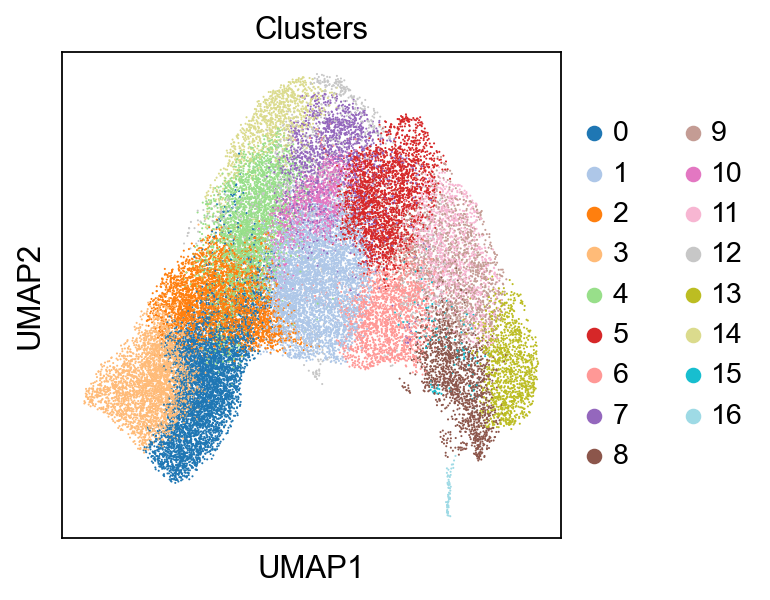

In [76]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

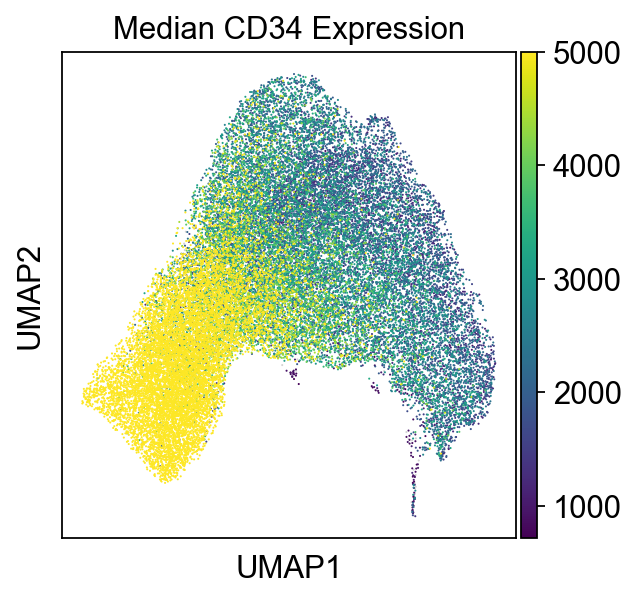

In [77]:
sc.pl.umap(
    adata, 
    color=['CD34_median'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Median CD34 Expression"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


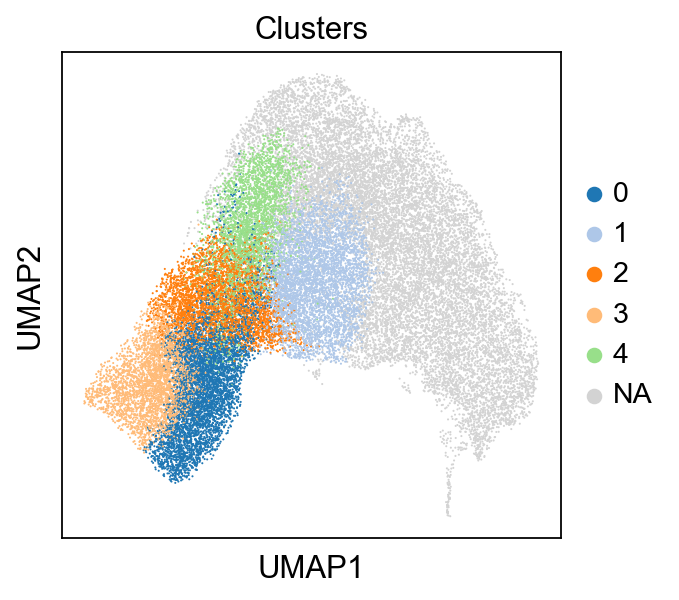

In [86]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[0,1,2,3,4]
)

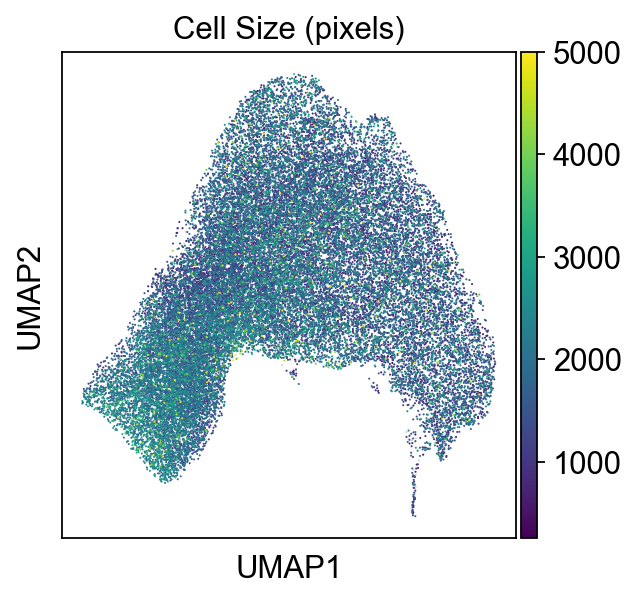

In [80]:
sc.pl.umap(
    adata, 
    color=['Size (pixels)'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Cell Size (pixels)"],
    vmax=5000
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


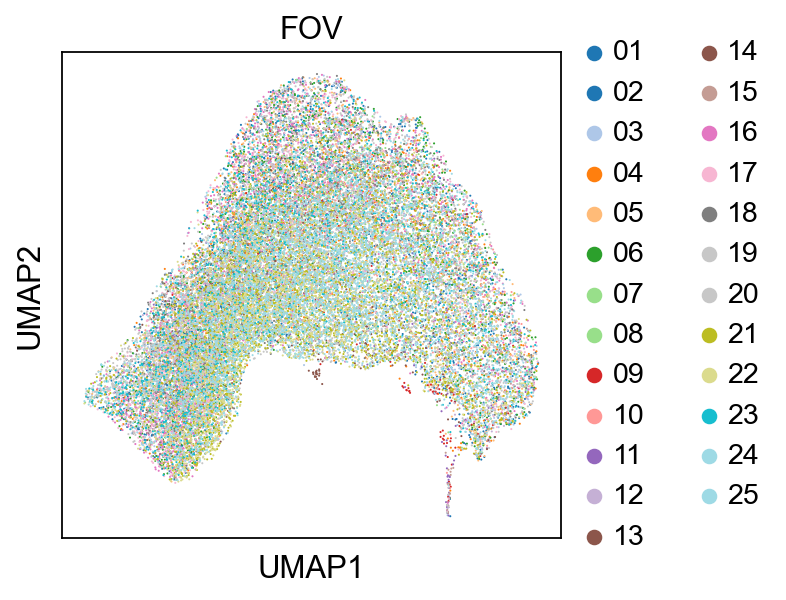

In [81]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [82]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv(pt + '_CD34_subclusters.csv')

In [83]:
# save clustered data anndata object
adata.write_h5ad(pt + '_CD34_cell_features_subclustered.h5ad')